# ✏️ Esercizio

## Preparazione del Notebook

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import warnings
from cmdstanpy import cmdstan_path, CmdStanModel

In [24]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

{cite:t}`yalch2016applying` offre un'illustrazione pratica dell'impiego dell'analisi bayesiana nell'ambito degli studi sul trauma, concentrandosi in particolare sugli effetti delle esperienze traumatiche che variano per grado di tradimento interpersonale (basso, medio e alto) sulla manifestazione dei sintomi associati al disturbo da stress post-traumatico (PTSD). Ricerche e teorizzazioni antecedenti hanno ipotizzato che le esperienze traumatiche caratterizzate da un elevato livello di tradimento interpersonale (definito come "alto tradimento") possano avere un impatto particolarmente negativo sui sintomi del PTSD, come sostenuto da Freyd & Birrell (2013). Questa correlazione, però, è stata prevalentemente documentata in campioni occidentali e primariamente caucasici.

Nella sua indagine, {cite:t}`yalch2016applying` ha esplorato l'effetto del tradimento interpersonale elevato sui sintomi del PTSD in un campione ristretto di studenti universitari afroamericani (N = 27), estratto da un'indagine più ampia sulla salute psicologica degli studenti universitari (N = 296; Yalch & Levendosky, 2014). È importante notare che le minoranze etniche, e in particolare gli individui che si identificano come neri, sono frequentemente sottorappresentati nella ricerca sul trauma psicologico, una circostanza attribuibile in parte alla scarsità di campioni di minoranze etniche (cfr. Marsella, Friedman, Gerrity, & Scurfield, 1996).

I partecipanti di questo sotto-campione hanno completato il *PTSD Symptom Checklist per il DSM-5* (PCL-5; Weathers et al., 2013) e il *Brief Betrayal Trauma Survey* (BBTS; Goldberg & Freyd, 2006). 


```note
Per ciascun item qui sotto, i partecipanti riportano l'esposizione "prima dei 18 anni" (per i numeri di item inferiori, cioè da 1 a 12) e "dai 18 anni in poi" (per i numeri di item superiori, cioè da 13 a 24). Le scelte di risposta sono: mai, 1 o 2 volte, più di questo.

1/13. Avere vissuto un importante terremoto, incendio, alluvione, uragano o tornado che ha causato una significativa perdita di beni personali, lesioni gravi a te stesso o a una persona significativa, la morte di una persona significativa o la paura della tua morte.

2/14. Essere stato coinvolto in un grave incidente automobilistico, in barca, in moto, in aereo, in treno o industriale che ha avuto conseguenze simili.

3/15. Avere assistito a qualcuno con cui eri molto vicino (come un genitore, un fratello o una sorella, un caregiver o un partner intimo) che si è suicidato, è stato ucciso o è stato ferito così gravemente da lasciare segni, lividi, ustioni, sangue o ossa rotte. Questo potrebbe includere un amico stretto in combattimento.

4/16. Avere assistito a qualcuno con cui non eri così vicino che ha subito un evento traumatico simile.

5/17. Avere assistito a qualcuno con cui eri molto vicino che ha deliberatamente attaccato un altro membro della famiglia in modo così grave da lasciare segni, lividi, sangue, ossa rotte o denti rotti.

6/18. Essere stato deliberatamente attaccato in modo così grave da qualcuno con cui eri molto vicino.

7/19. Essere stato deliberatamente attaccato in modo così grave da qualcuno con cui non eri vicino.

8/20. Essere costretto a subire una forma di contatto sessuale, come toccare o penetrazione, da parte di qualcuno con cui eri molto vicino (come un genitore o un amante).

9/21. Essere costretto a subire tale contatto sessuale da parte di qualcuno con cui non eri vicino.

10/22. Essere stato maltrattato emotivamente o psicologicamente per un periodo significativo da qualcuno con cui eri molto vicino (come un genitore o un amante).

11/23. Avere vissuto la morte di uno dei tuoi figli.

12/24. Avere vissuto un evento traumatico grave non già menzionato in nessuna di queste domande.
```

Il BBTS classifica le esperienze traumatiche in tre livelli di tradimento (basso, medio, alto) sulla base della media degli eventi riferiti in ciascun livello. Nel suo studio, Yalch (2016) ha calcolato per ogni partecipante un punteggio relativo alla frequenza di esposizione al tradimento interpersonale (basso, medio e alto), utilizzando tali punteggi come variabili indipendenti in un modello di regressione binomiale con i sintomi del PTSD come variabile dipendente.

In questa esercitazione, ci ispiriamo allo studio di Yalch e applichiamo l'analisi a un set di dati ipotetico, dato che i dati originali non sono disponibili. Consideriamo un campione di 27 studenti, dei quali 4 riportano di aver sperimentato un alto livello di tradimento interpersonale. Data la dimensione limitata del campione, intendiamo quantificare l'incertezza associata a questi dati. A tal fine, adottiamo un prior debolmente informativo su $\theta$ (la probabilità di alto tradimento), rappresentato da una distribuzione Beta(2, 2).

Il modello analitico proposto è il seguente:

$$
\begin{align*}
\theta &\sim \text{Beta}(2, 2), \\
y &\sim \text{Bin}(n, \theta),
\end{align*}
$$

dove $y = 4$ rappresenta il numero di studenti che hanno sperimentato un alto livello di tradimento interpersonale, e $n = 27$ è il totale dei partecipanti al campione.

Il modello in linguaggio Stan è contenuto nel file `stan/binomial_model.stan`. Possiamo stamparlo nel notebook nel modo seguente:

In [46]:
stan_file = os.path.join('stan', 'binomial_model.stan')
print(stan_file)

stan/binomial_model.stan


In [6]:
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> ntrials; // Numero di prove
  int<lower=0> y; // Successi osservati
  real<lower=0> alpha_prior; // Parametro alpha per il prior Beta
  real<lower=0> beta_prior; // Parametro beta per il prior Beta
}
parameters {
  real<lower=0, upper=1> theta; // Parametro stimato, limitato tra 0 e 1
}
model {
  // Prior
  theta ~ beta(alpha_prior, beta_prior);
  
  // Likelihood
  y ~ binomial(ntrials, theta);
}



1. **Data Block (Blocco dei dati):**
```stan
data {
  int<lower=0> ntrials; // Numero di prove
  int<lower=0> y; // Successi osservati
  real<lower=0> alpha_prior; // Parametro alpha per il prior Beta
  real<lower=0> beta_prior; // Parametro beta per il prior Beta
}
```
In questa sezione vengono definiti i dati che vengono inseriti nel modello. Questi dati includono:
- `ntrials`: il numero totale di prove eseguite.
- `y`: il numero di successi osservati (ad esempio, il numero di volte in cui un evento desiderato si è verificato).
- `alpha_prior` e `beta_prior`: i parametri della distribuzione Beta che rappresentano la nostra conoscenza a priori o le nostre credenze prima di osservare i dati.

2. **Parameters Block (Blocco dei parametri):**
```stan
parameters {
  real<lower=0, upper=1> theta; // Parametro stimato, limitato tra 0 e 1
}
```
In questa sezione vengono definiti i parametri del modello che desideriamo stimare. Nel nostro caso, abbiamo un unico parametro `theta`, che rappresenta la proporzione di successi nelle prove (il tasso di successo). La sintassi `<lower=0, upper=1>` indica che `theta` deve essere compreso tra 0 e 1, poiché rappresenta una probabilità.

3. **Model Block (Blocco del modello):**
```stan
model {
  // Prior
  theta ~ beta(alpha_prior, beta_prior);
  
  // Likelihood
  y ~ binomial(ntrials, theta);
}
```
In questa sezione definiamo il modello probabilistico stesso. Qui ciò che viene fatto è:
- **Prior (a priori)**: Definiamo la nostra conoscenza a priori o le nostre credenze prima di osservare i dati. Utilizziamo una distribuzione Beta con parametri `alpha_prior` e `beta_prior` per rappresentare questa conoscenza a priori su `theta`, il parametro che vogliamo stimare.
- **Likelihood (verosimiglianza)**: Questa parte del modello descrive come i dati sono generati. In questo caso, stiamo utilizzando una distribuzione binomiale per modellare il numero di successi `y` in `ntrials` prove, con una probabilità di successo `theta`. Questo è ciò che definisce il modo in cui i dati sono collegati ai parametri del modello.

In sintesi, il codice definisce un modello bayesiano che stima la proporzione di successi `theta` in una serie di prove, utilizzando informazioni a priori su `theta` e i dati osservati `y` e `ntrials`.

Compiliamo il modello.

In [7]:
model = CmdStanModel(stan_file=stan_file)
print(model)

CmdStanModel: name=binomial_model
	 stan_file=/Users/corrado/_repositories/ds4p/chapter_4/stan/binomial_model.stan
	 exe_file=/Users/corrado/_repositories/ds4p/chapter_4/stan/binomial_model
	 compiler_options=stanc_options={}, cpp_options={}


I dati devono essere contenuti in un dizionario. Nel caso presente, il dizionario `data` può essere creato nel modo seguente.

In [8]:
data = {
    "ntrials" : 27,
    "y" : 4,
    "alpha_prior" : 2,
    "beta_prior" : 2
}
print(data)

{'ntrials': 27, 'y': 4, 'alpha_prior': 2, 'beta_prior': 2}


Possiamo ora eseguire il campionamento MCMC con la seguente chiamata.

In [9]:
fit = model.sample(
    data=data,
    iter_sampling = 4000,
    iter_warmup = 2000,
    seed = 84735,
    chains = 4
)

08:29:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:29:28 - cmdstanpy - INFO - CmdStan done processing.


Si noti che `$sample()` rappresenta un "metodo" applicato al file eseguibile che abbiamo precedentemente compilato e denominato `model`.

Questo metodo richiede diversi argomenti:

- `data`: i dati di input, solitamente contenuti in un dizionario (come nel caso attuale, `data`).
- `chains`: specifica il numero di catene di Markov parallele da eseguire. Nell'esempio corrente, eseguiamo quattro catene per ottenere quattro campioni distinti di valori di $\theta$.
- `iter`: indica il numero totale di iterazioni o la lunghezza di ogni catena di Markov. Per impostazione predefinita, la prima metà di queste iterazioni è utilizzata per il "burn-in", ovvero per raggiungere la stabilità. La seconda metà costituisce un campione della distribuzione a posteriori.
- `iter_warmup`: specifica il numero di iterazioni iniziali da ignorare durante il "burn-in".
- `seed`: imposta il seme casuale utilizzato per inizializzare ciascuna catena di Markov.

Poiché abbiamo specificato una distribuzione a priori per il parametro $\theta$, l'algoritmo procede iterativamente, aggiustando la distribuzione a priori di $\theta$ in base ai valori già generati. Dopo un numero sufficiente di iterazioni per raggiungere la convergenza dell'algoritmo, i valori estratti possono essere considerati campioni dalla distribuzione a posteriori di $\theta$.

Con l'aumentare del numero di iterazioni della catena, l'approssimazione della distribuzione di target migliora progressivamente. Tuttavia, all'inizio del campionamento, la distribuzione può essere distante dalla stazionaria e richiede un periodo di "burn-in" per raggiungere l'equilibrio. Durante questo periodo, i campioni iniziali possono non essere rappresentativi della distribuzione a posteriori e vengono comunemente scartati.

In [29]:
print(fit.diagnose())

Processing csv files: /var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/tmp1n1pej6f/binomial_modelpcsch5aj/binomial_model-20240410082928_1.csv, /var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/tmp1n1pej6f/binomial_modelpcsch5aj/binomial_model-20240410082928_2.csv, /var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/tmp1n1pej6f/binomial_modelpcsch5aj/binomial_model-20240410082928_3.csv, /var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/tmp1n1pej6f/binomial_modelpcsch5aj/binomial_model-20240410082928_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



L'oggetto `fit` restituito da `cmdstanpy` è un'istanza della classe `cmdstanpy.stanfit.mcmc.CmdStanMCMC`. Questo oggetto ha la stessa funzionalità di un oggetto della classe `InferenceData`, consentendo di manipolarlo utilizzando le funzioni fornite da ArviZ.

In [30]:
type(fit)

cmdstanpy.stanfit.mcmc.CmdStanMCMC

Troviamo la media a posteriori di $\theta$ e l'intervallo di credibilità al 94%.

In [13]:
az.summary(fit, var_names=("theta"), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.194,0.07,0.071,0.325,0.001,0.001,5587.0,6107.0,1.0


Visualizziamo la distribuzione a posteriori del parametro $\theta$.

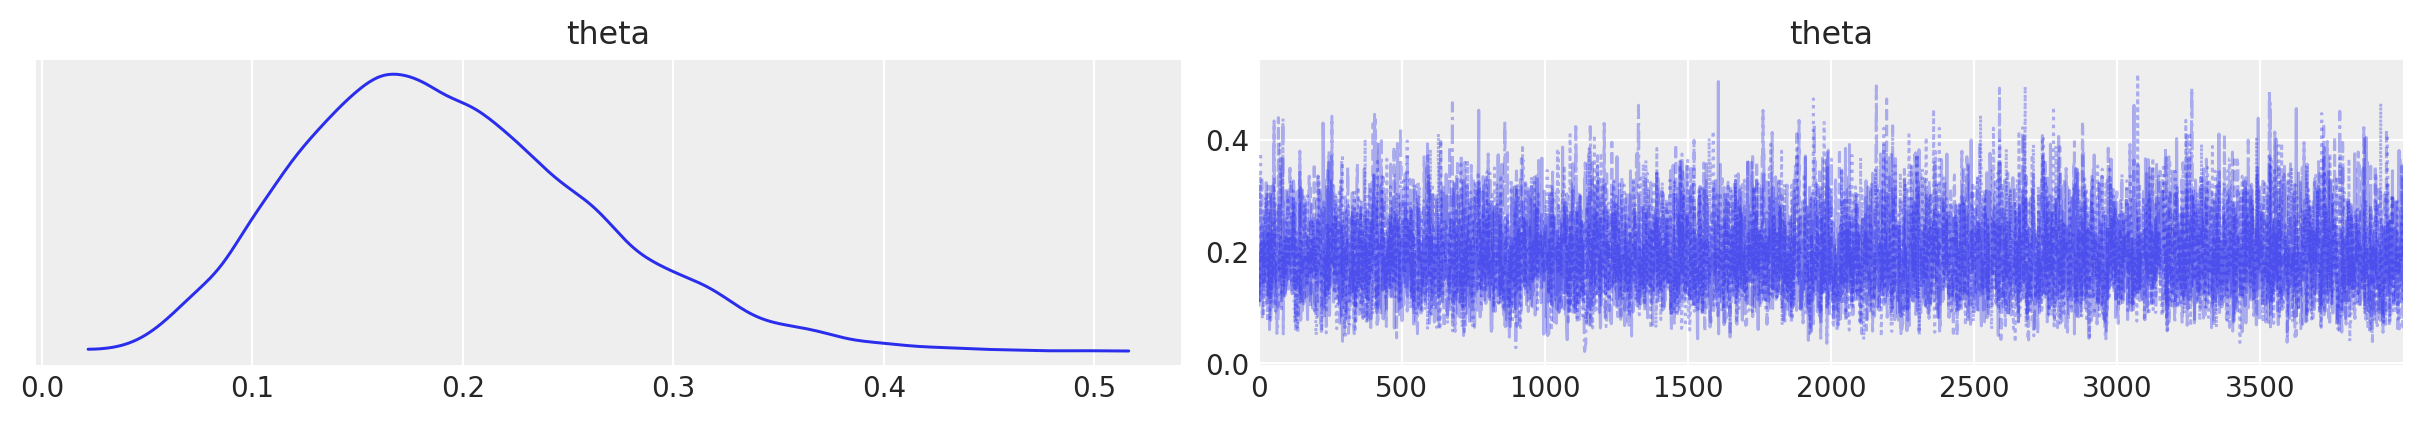

In [14]:
_ = az.plot_trace(fit, var_names=("theta"), combined=True)

Possiamo anche manipolare direttamente i valori prodotti dal campionamento. Estraiamo i campioni a posteriori:

In [32]:
post = az.extract(fit)
post

<xarray.Dataset> Size: 512kB
Dimensions:  (sample: 16000)
Coordinates:
  * sample   (sample) object 128kB MultiIndex
  * chain    (sample) int64 128kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 128kB 0 1 2 3 4 5 ... 3994 3995 3996 3997 3998 3999
Data variables:
    theta    (sample) float64 128kB 0.1627 0.1545 0.1953 ... 0.3257 0.2505
Attributes:
    created_at:                 2024-04-10T06:36:29.433950+00:00
    arviz_version:              0.18.0
    inference_library:          cmdstanpy
    inference_library_version:  1.2.2

Un vettore con i 16000 valori estratti dalla distribuzione a posteriori si ottiene nel modo seguente.

In [33]:
post["theta"].shape

(16000,)

Utilizziamo MatPlotLib per creare un istogramma della distribuzione a posteriori del parametro $\theta$.

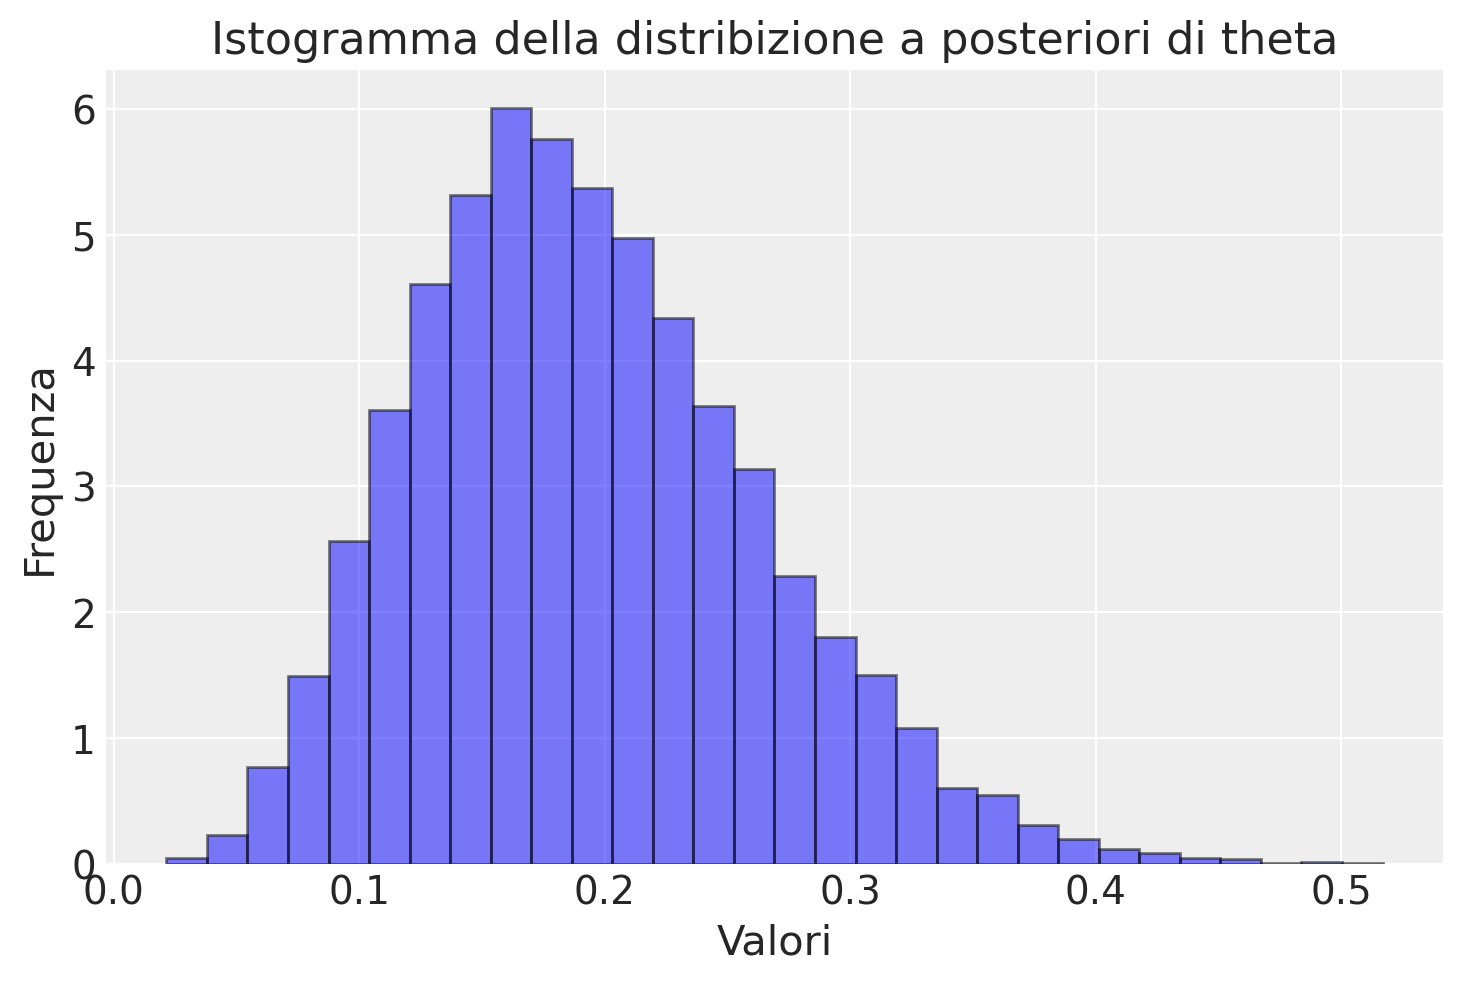

In [34]:
plt.hist(post["theta"], bins=30, alpha=0.5, color='b', edgecolor='black', density=True)

# Aggiunta di titolo e etichette agli assi
plt.title('Istogramma della distribizione a posteriori di theta')
plt.xlabel('Valori')
plt.ylabel('Frequenza')

plt.show()

A partire dai campioni a posteriori, calcoliamo la media a posteriori:

In [35]:
np.mean(post["theta"].values)

0.19361956193750002

Verifichiamo che questo valore corrisponda al valore teorico atteso:

In [39]:
alpha_post = data["alpha_prior"] + data["y"]
beta_post = data["beta_prior"] + data["ntrials"] - data["y"]

alpha_post / (alpha_post + beta_post)

0.1935483870967742

Le istruzioni successive possono essere impiegate per visualizzare sia la distribuzione a posteriori ottenuta tramite cmdstan, sia quella derivata analiticamente.

In [40]:
alpha_prior = data["alpha_prior"]
beta_prior = data["beta_prior"]

n = data["ntrials"]
y = data["y"]

Text(0, 0.5, 'Densità')

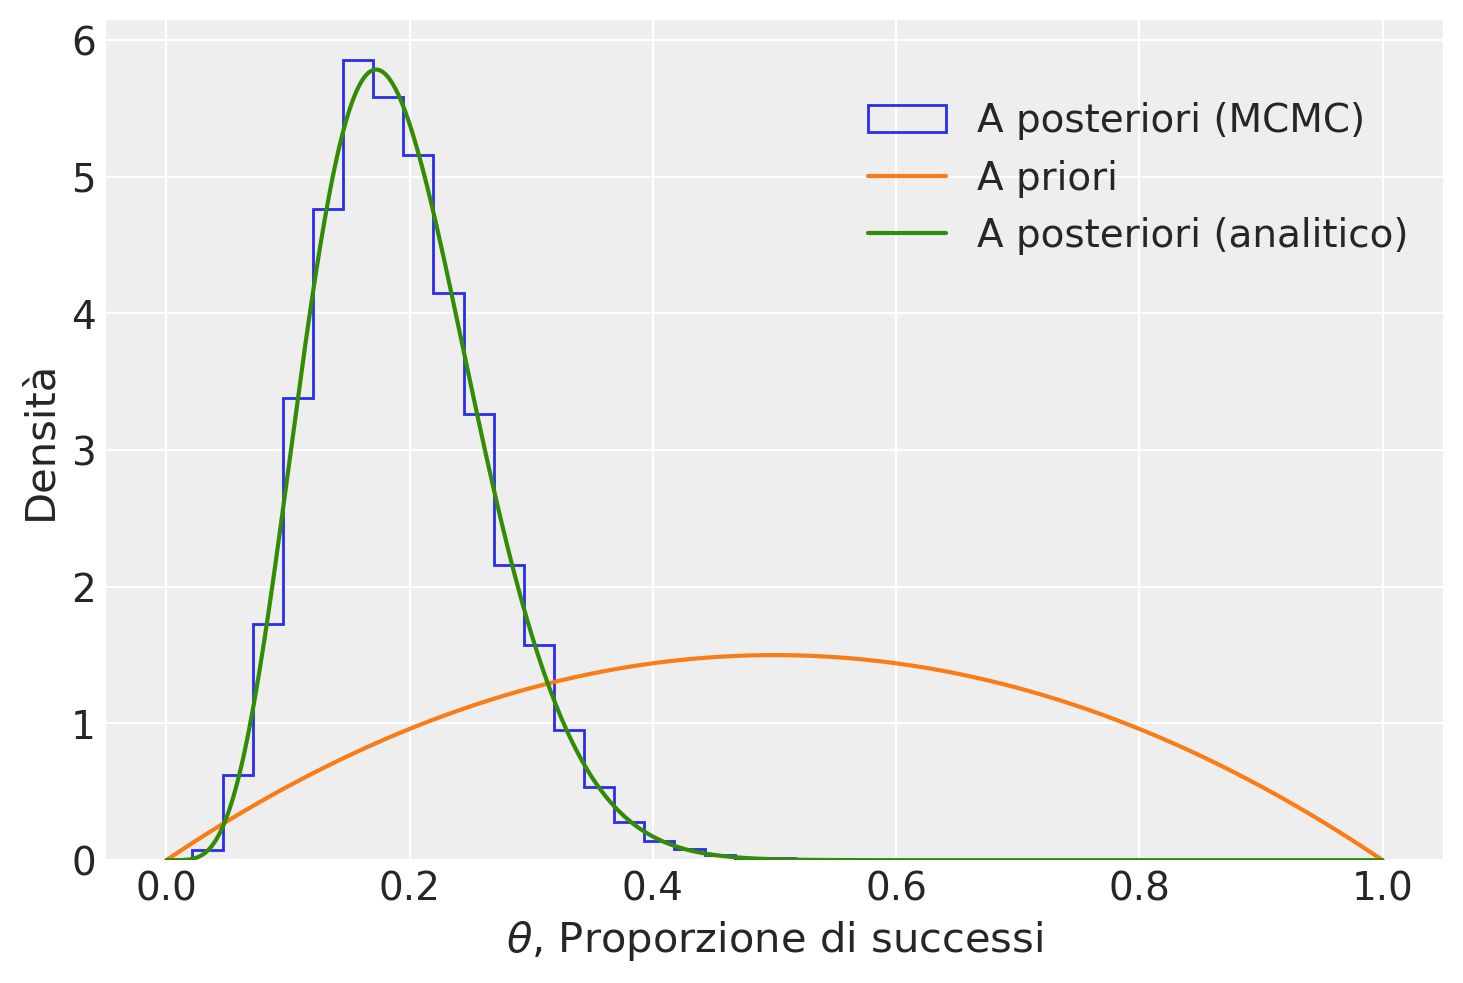

In [42]:
p_post = post["theta"]

# Posterior: Beta(alpha + y, beta + n - y)
alpha_post = alpha_prior + y
beta_post = beta_prior + n - y

plt.hist(
    p_post,
    bins=20,
    histtype="step",
    density=True,
    label="A posteriori (MCMC)",
    color="C0",
)

# Plot the analytic prior and posterior beta distributions
x = np.linspace(0, 1, 500)
plt.plot(
    x, stats.beta.pdf(x, alpha_prior, beta_prior), label="A priori", color="C1"
)
plt.plot(
    x,
    stats.beta.pdf(x, alpha_post, beta_post),
    label="A posteriori (analitico)",
    color="C2",
)

# Update the graph labels
plt.legend(title=" ", loc="best")
plt.xlabel("$\\theta$, Proporzione di successi")
plt.ylabel("Densità")

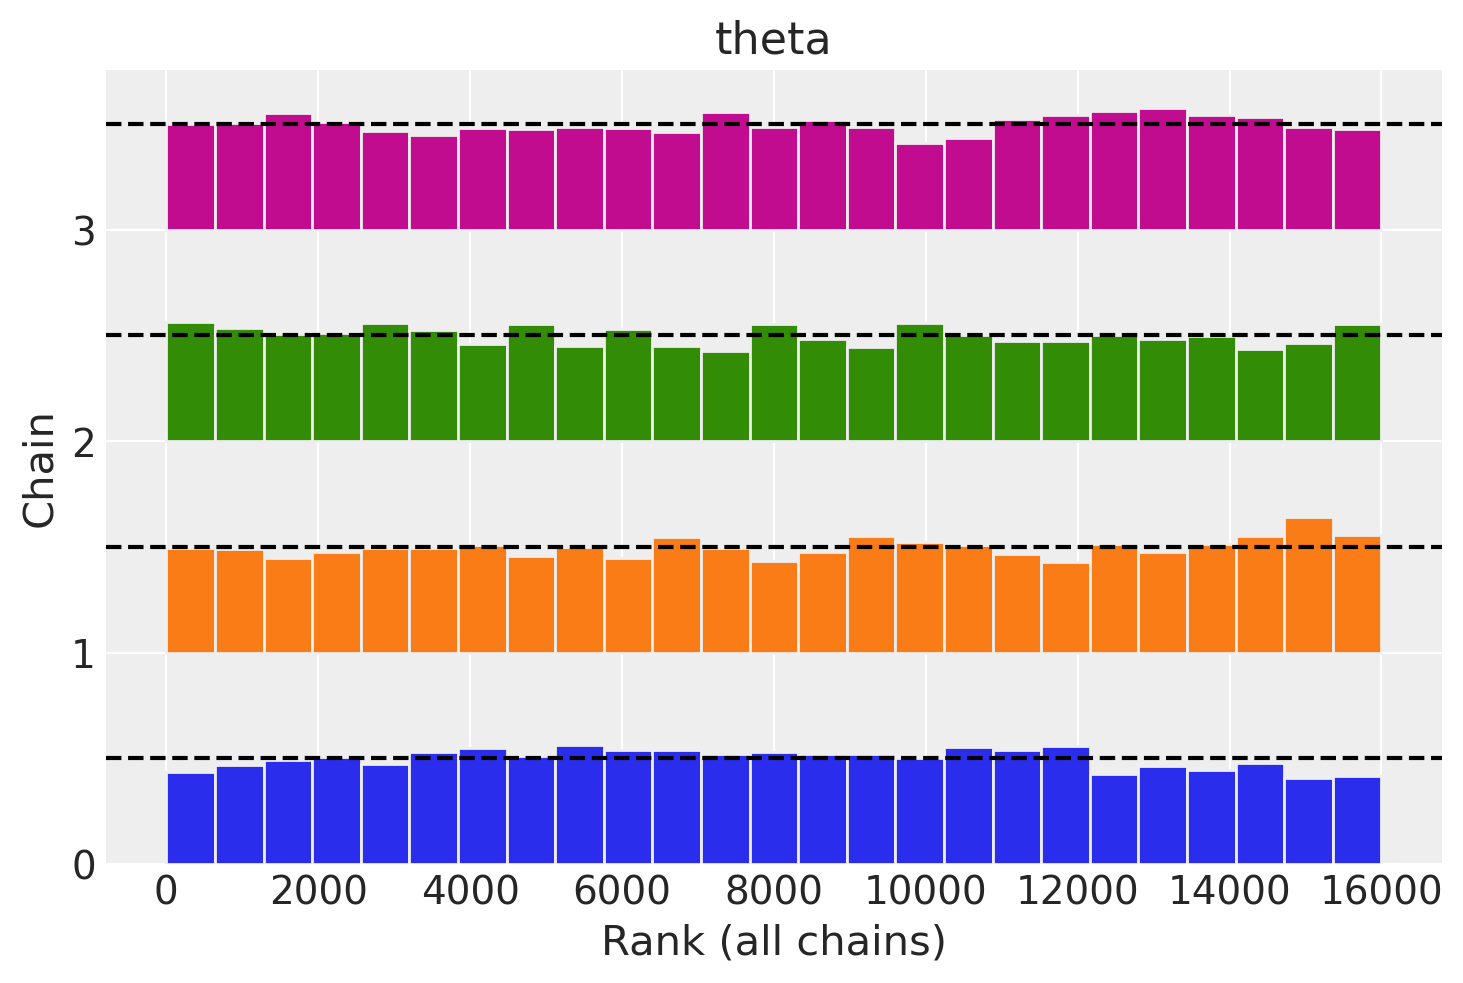

In [23]:
_ = az.plot_rank(fit, var_names="theta", kind="bars")

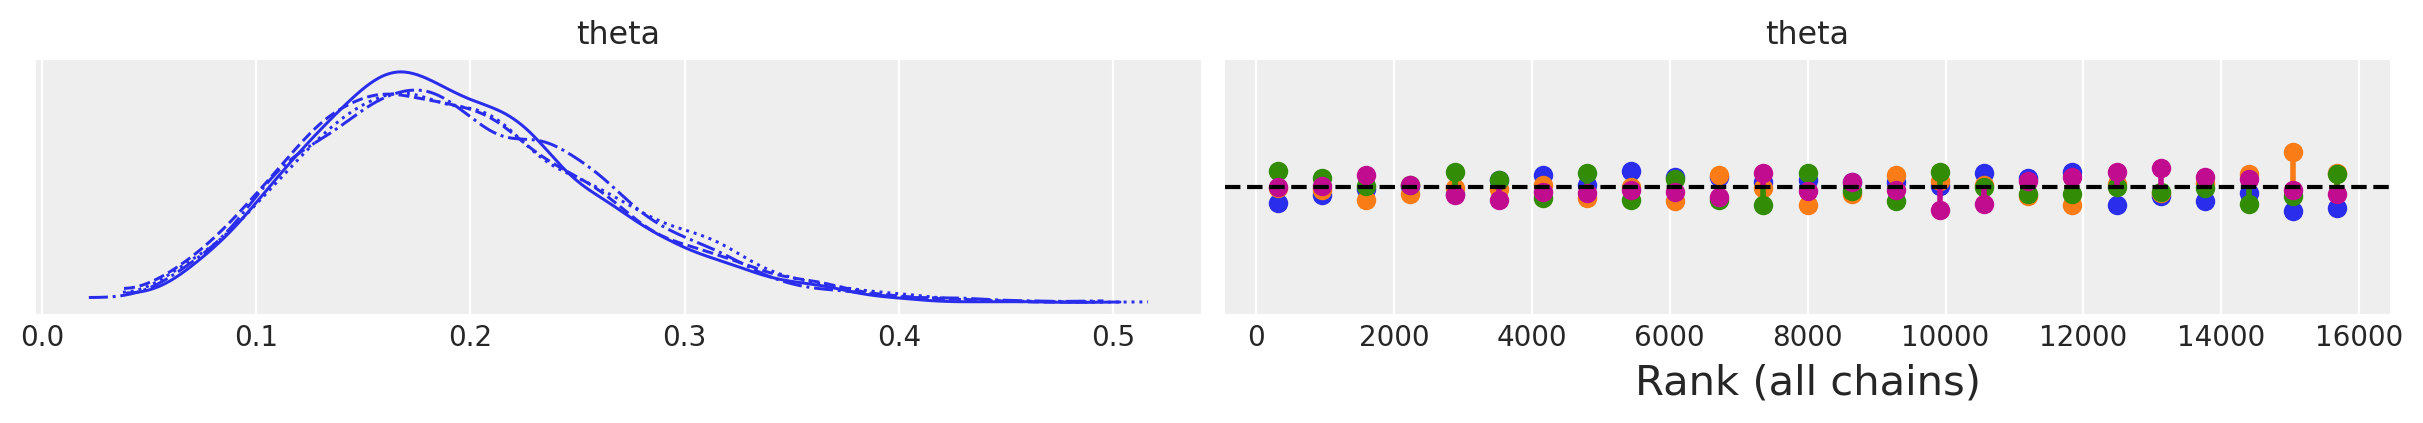

In [43]:
_ = az.plot_trace(fit, var_names=("theta"), kind="rank_vlines")

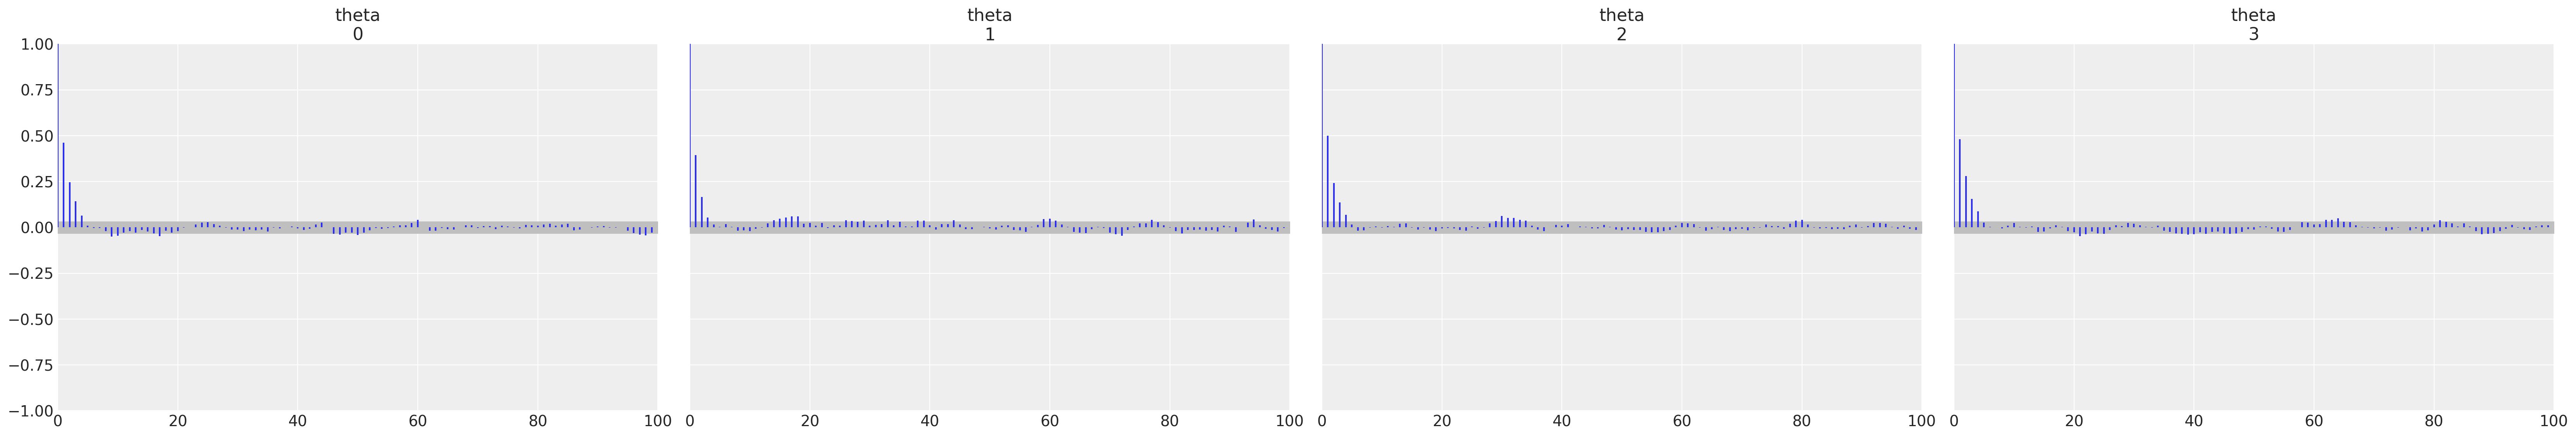

In [44]:
_ = az.plot_autocorr(fit, var_names=("theta"))

Possiamo quindi concludere che, considerando sia le nostre credenze iniziali che i dati osservati, la frequenza dei livelli elevati di tradimento interpersonale può essere stimata tra il 7% e il 32% nella popolazione considerata, con un livello di certezza soggettiva del 94%. Inoltre, il valore più probabile a posteriori è del 19%.

## Prior informativi

Secondo quanto affermato da {cite:t}`yalch2016applying`, a causa delle dimensioni ridotte di questo campione, l'integrazione di un prior informato da precedenti ricerche potrebbe portare a risultati diversi (e forse più credibili). In uno studio condotto da {cite:t}`goldberg2006self` attraverso il *Brief Betrayal Trauma Survey*, sono stati raccolti i dati di due campioni, a tre anni di distanza, comprendenti 397 donne e 292 uomini che hanno completato il sondaggio in entrambe le occasioni. Dai dati è emerso che circa il 30% degli uomini e il 50% delle donne ha riportato di aver vissuto almeno un episodio di alto tradimento interpersonale. Di conseguenza, possiamo adottare un prior informativo con una media approssimativa del 0.4. A tal fine, useremo una distribuzione Beta(28, 70).

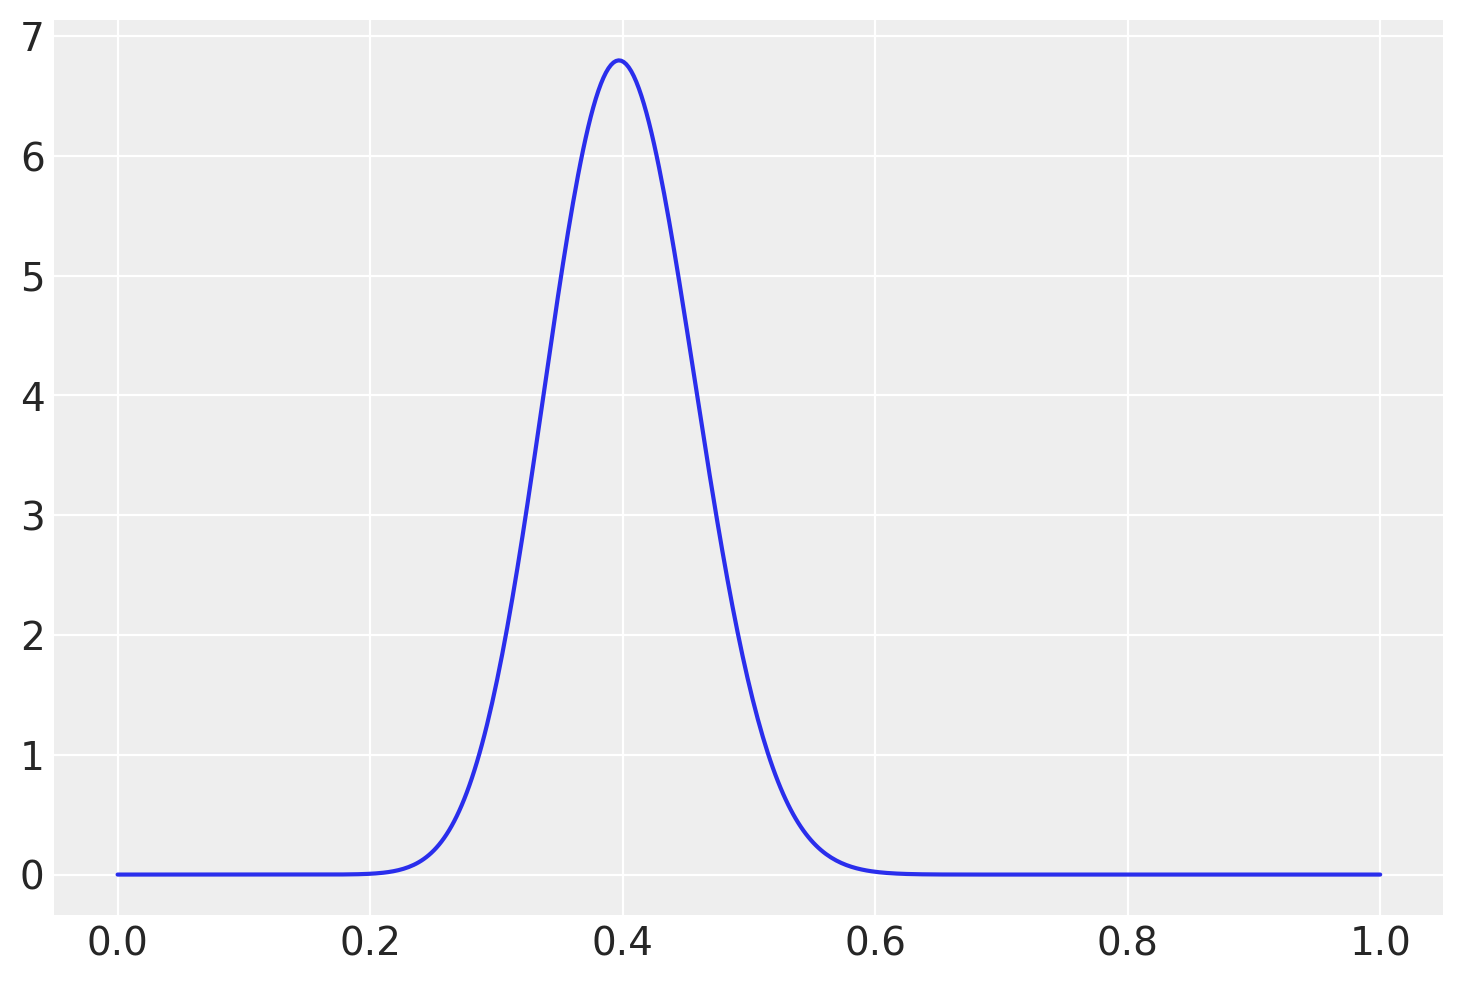

In [55]:
x = np.linspace(0, 1, 500)
_ = plt.plot(x, stats.beta.pdf(x, 28, 70-28))

Con questo nuovo prior, calcoliamo nuovamente la distribuzione a posteriori di $\theta$.

In [57]:
data = {
    "ntrials" : 27,
    "y" : 4,
    "alpha_prior" : 28,
    "beta_prior" : 42
}
print(data)

{'ntrials': 27, 'y': 4, 'alpha_prior': 28, 'beta_prior': 42}


In [58]:
fit2 = model.sample(
    data=data,
    iter_sampling = 4000,
    iter_warmup = 2000,
    seed = 84735,
    chains = 4
)

09:22:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:22:57 - cmdstanpy - INFO - CmdStan done processing.


In [59]:
az.summary(fit2, var_names=("theta"), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.33,0.047,0.243,0.417,0.001,0.0,6136.0,8451.0,1.0


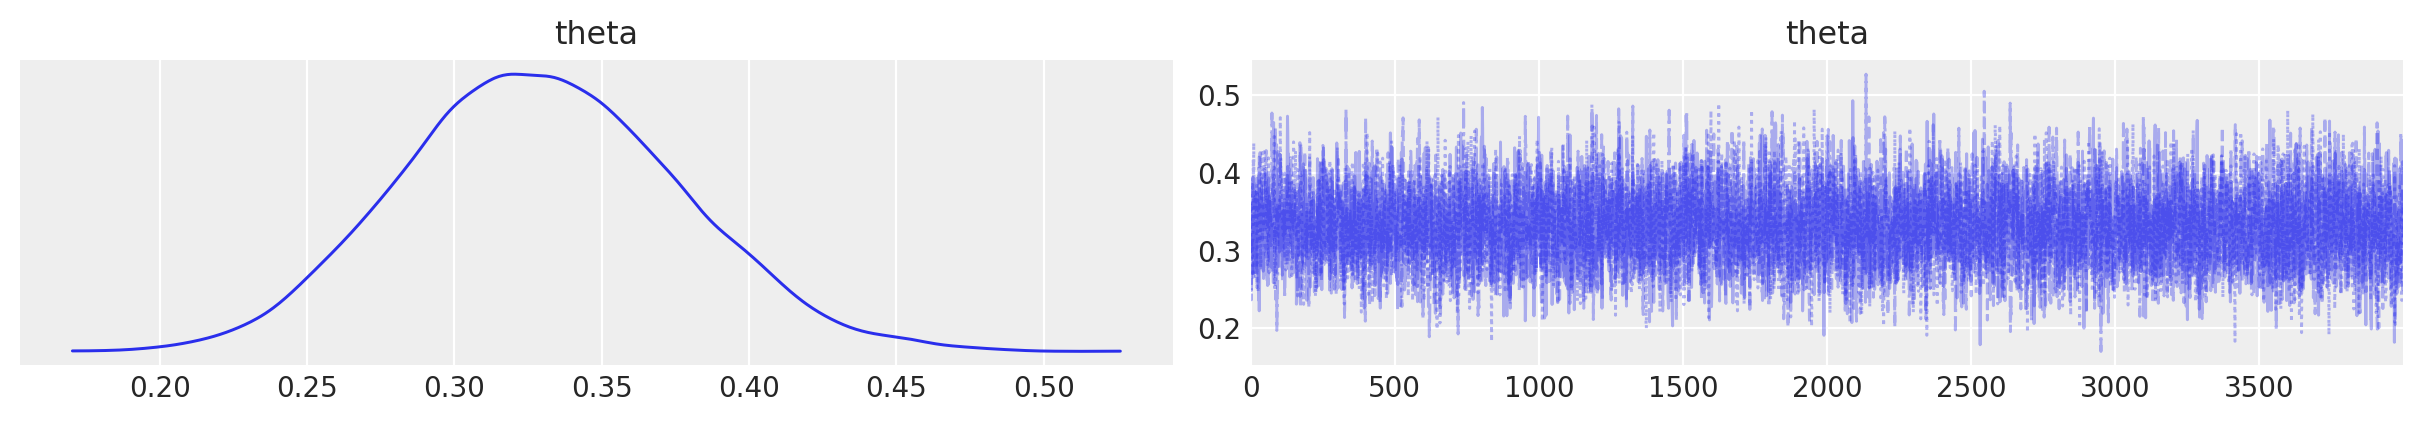

In [60]:
_ = az.plot_trace(fit2, var_names=("theta"), combined=True)

Grazie all'utilizzo di un prior informativo, osserviamo un notevole incremento nella nostra stima della probabilità a posteriori di aver sperimentato almeno un episodio di alto tradimento interpersonale. Questo fenomeno è attribuibile al fatto che, in presenza di un campione di dimensioni ridotte, l'influenza del prior risulta particolarmente rilevante.

## Distribuzione predittiva a posteriori

Per trovare la distribuzione predittiva a posteriori usando Stan, dobbiamo aggiungere il blocco `generated quantities`.

In [25]:
stan_file = os.path.join('stan', 'binomial_model2.stan')
print(stan_file)

stan/binomial_model2.stan


In [26]:
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> ntrials; // Numero di prove
  int<lower=0> y; // Successi osservati
  real<lower=0> alpha_prior; // Parametro alpha per il prior Beta
  real<lower=0> beta_prior; // Parametro beta per il prior Beta
}
parameters {
  real<lower=0, upper=1> theta; // Parametro stimato, limitato tra 0 e 1
}
model {
  // Prior
  theta ~ beta(alpha_prior, beta_prior);
  
  // Likelihood
  y ~ binomial(ntrials, theta);
}
generated quantities {
  int<lower=0> y_pred; // Variabile per la distribuzione predittiva a posteriori
  
  // Generazione dei dati predittivi a posteriori
  // Usa il valore di theta stimato per generare un nuovo risultato
  // da una distribuzione binomiale
  y_pred = binomial_rng(ntrials, theta);
}




In questo blocco, la funzione `binomial_rng()` genera in modo casuale un valore $y$, rappresentante il numero di "successi", per ogni valore della distribuzione a posteriori di $\theta$, considerando un numero `ntrial` di prove. Questo processo riflette precisamente la distribuzione predittiva a posteriori.i `ntrial` prove. Questo corrisponde esattamente alla distribuzione predittiva a posteriori. 

Eseguiamo nuovamente il campionamento usando il codice Stan aggiornato.

In [27]:
data = {
    "ntrials" : 27,
    "y" : 4,
    "alpha_prior" : 2,
    "beta_prior" : 2
}
print(data)

{'ntrials': 27, 'y': 4, 'alpha_prior': 2, 'beta_prior': 2}


In [28]:
model2 = CmdStanModel(stan_file=stan_file)
print(model2)

CmdStanModel: name=binomial_model2
	 stan_file=/Users/corrado/_repositories/ds4p/chapter_4/stan/binomial_model2.stan
	 exe_file=/Users/corrado/_repositories/ds4p/chapter_4/stan/binomial_model2
	 compiler_options=stanc_options={}, cpp_options={}


In [29]:
fit2 = model2.sample(
    data=data,
    iter_sampling = 4000,
    iter_warmup = 2000,
    seed = 84735,
    chains = 4
)

12:19:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:19:50 - cmdstanpy - INFO - CmdStan done processing.


Visualizziamo la distribuzione predittiva a posteriori.

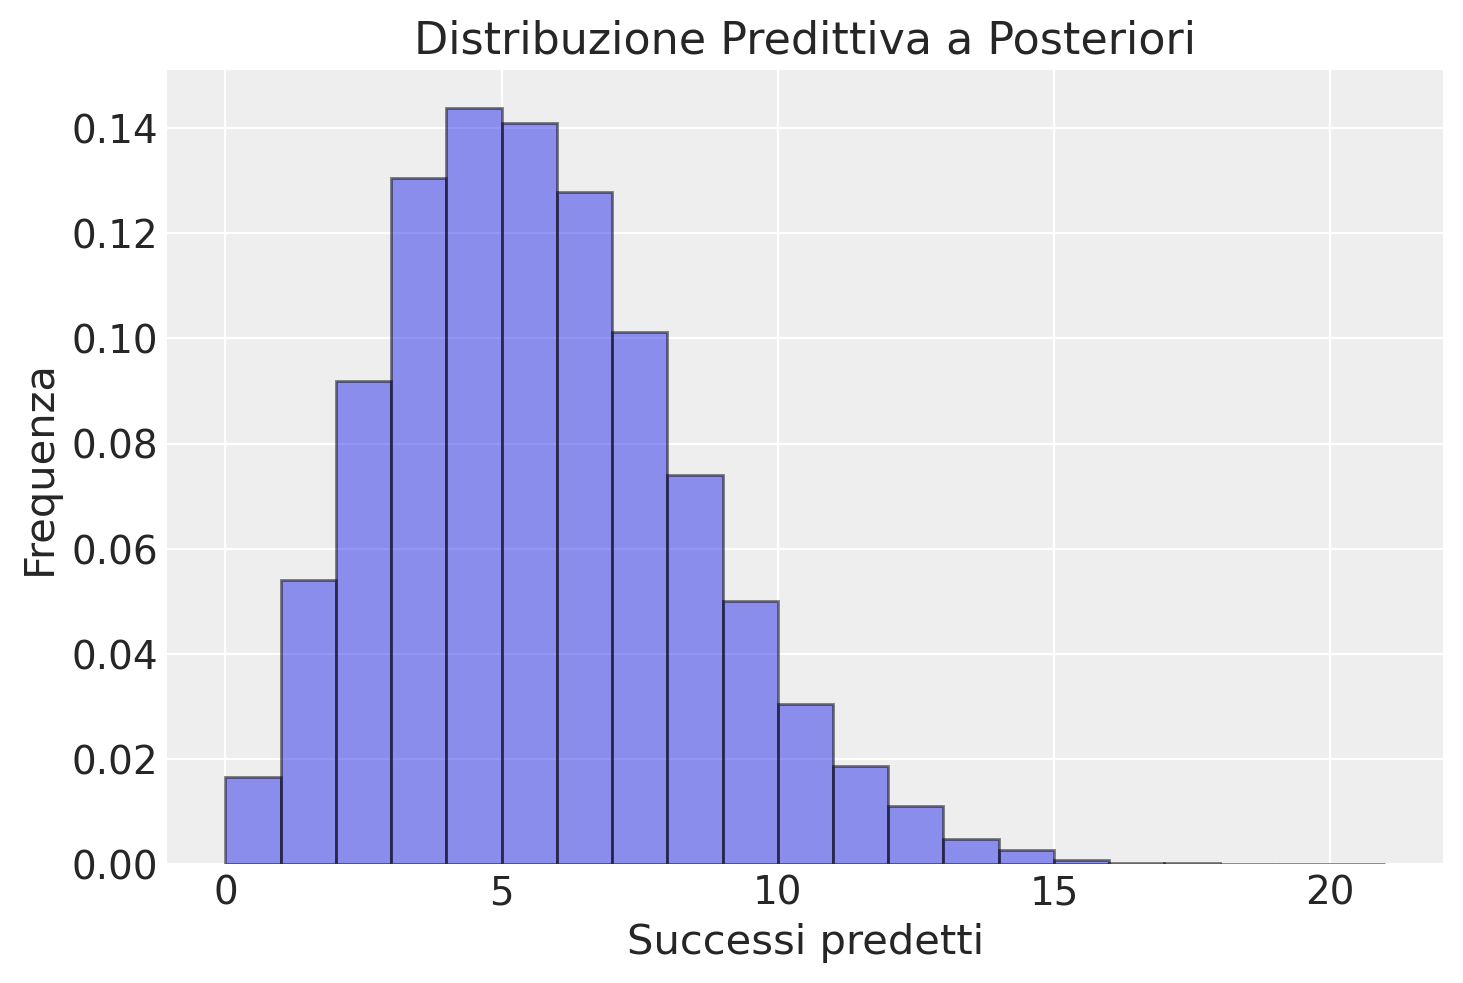

In [30]:
# 'y_pred' è il nome della variabile generata nella sezione `generated quantities` del modello Stan
y_pred = fit2.stan_variable('y_pred')

# Visualizza la distribuzione predittiva a posteriori
plt.hist(y_pred, alpha=0.5, edgecolor='black', density=True, bins=range(0, 22))
plt.title('Distribuzione Predittiva a Posteriori')
plt.xlabel('Successi predetti')
plt.ylabel('Frequenza')
plt.show()

In un nuovo campione di 27 osservazioni, ci possiamo dunque aspettare una media di 5.2 individui che affermano di avere esperito almeno un episodio di tradimento interpersonale grave.

In [31]:
np.mean(y_pred)

5.1920625

È possibile usare le funzioni di Arviz per creare la distribuzione predittiva a posteriori. Tuttavia, nel caso presente, i dati ($y$ = 4) sono un singolo valore e, in tali circostanze, le fuzioni di Arviz non possono essere usate. Per usare le funzioni di Arviz per i PPC, sarebbe necessario fittare un modello bernoulliano, con i dati che corrispondono a 4 valori 0 e 23 valori 1. 

## Distribuzione predittiva a priori

Nella distribuzione predittiva a priori, siamo interessati a simulare dati possibili basati esclusivamente sui prior, senza considerare i dati osservati. Ciò significa che, nella sezione `generated quantities`, dobbiamo generare dati simulati ($y_{pred}$) utilizzando campioni tratti direttamente dai prior per il parametro $\theta$, piuttosto che utilizzare il valore di $\theta$ stimato dal modello che include i dati osservati. Ecco come modificare il codice:

```stan
data {
  int<lower=0> ntrials; // Numero di prove
  // Rimuovi la variabile 'y' poiché non si basa su dati osservati
  real<lower=0> alpha_prior; // Parametro alpha per il prior Beta
  real<lower=0> beta_prior; // Parametro beta per il prior Beta
}
parameters {
  // Non sono necessari cambiamenti qui
  real<lower=0, upper=1> theta; // Parametro stimato, limitato tra 0 e 1
}
model {
  // Prior
  theta ~ beta(alpha_prior, beta_prior);
  
  // Rimuovi la likelihood poiché stiamo generando dati a priori
}
generated quantities {
  int<lower=0> y_pred_prior; // Variabile per la distribuzione predittiva a priori
  
  // Generazione dei dati predittivi a priori
  // Usa campioni tratti dai prior per theta per generare un nuovo risultato
  // da una distribuzione binomiale senza considerare 'y'
  y_pred_prior = binomial_rng(ntrials, beta_rng(alpha_prior, beta_prior));
}
```

Nelle modifiche sopra:
- Si rimuove la variabile `y` dai dati, poiché stiamo lavorando senza considerare i dati osservati.
- Si elimina la parte della verosimiglianza dal modello perché non vogliamo che i dati osservati influenzino la generazione dei dati predittivi a priori.
- Nella sezione `generated quantities`, si cambia il nome della variabile in `y_pred_prior` per riflettere che stiamo generando dati predittivi a priori. Inoltre, si modifica la generazione di `y_pred_prior` in modo che si basi su un campione dalla distribuzione Beta, utilizzando i priori `alpha_prior` e `beta_prior`, per simulare più direttamente dal prior piuttosto che da un valore di $\theta$ inferito.

Questo approccio simula direttamente i possibili risultati futuri ($y_{pred_prior}$) basati esclusivamente sui nostri prior, senza incorporare alcuna informazione dai dati osservati, in linea con l'obiettivo della distribuzione predittiva a priori.

In [32]:
stan_file = os.path.join('stan', 'binomial_model3.stan')
print(stan_file)

stan/binomial_model3.stan


In [33]:
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> ntrials; // Numero di prove
  // Si rimuove la variabile 'y' poiché non utilizziamo dati osservati
  real<lower=0> alpha_prior; // Parametro alpha per il prior Beta
  real<lower=0> beta_prior; // Parametro beta per il prior Beta
}
parameters {
  real<lower=0, upper=1> theta; // Parametro stimato, limitato tra 0 e 1
}
model {
  // Prior
  theta ~ beta(alpha_prior, beta_prior);
  
  // Si rimuove la likelihood poiché stiamo generando dati a priori
}
generated quantities {
  int<lower=0> y_pred_prior; // Variabile per la distribuzione predittiva a priori
  
  // Generazione dei dati predittivi a priori
  // Usiamo campioni tratti dai prior per theta per generare un nuovo risultato
  // da una distribuzione binomiale senza considerare 'y'
  y_pred_prior = binomial_rng(ntrials, beta_rng(alpha_prior, beta_prior));
}




In [34]:
model3 = CmdStanModel(stan_file=stan_file)
print(model3)

12:25:22 - cmdstanpy - INFO - compiling stan file /Users/corrado/_repositories/ds4p/chapter_4/stan/binomial_model3.stan to exe file /Users/corrado/_repositories/ds4p/chapter_4/stan/binomial_model3
12:25:53 - cmdstanpy - INFO - compiled model executable: /Users/corrado/_repositories/ds4p/chapter_4/stan/binomial_model3


CmdStanModel: name=binomial_model3
	 stan_file=/Users/corrado/_repositories/ds4p/chapter_4/stan/binomial_model3.stan
	 exe_file=/Users/corrado/_repositories/ds4p/chapter_4/stan/binomial_model3
	 compiler_options=stanc_options={}, cpp_options={}


In [42]:
data = {
    "ntrials" : 27,
    "alpha_prior" : 2,
    "beta_prior" : 2
}
print(data)

{'ntrials': 27, 'alpha_prior': 2, 'beta_prior': 2}


In [47]:
fit3 = model3.sample(
    data=data,
    iter_sampling = 4000,
    iter_warmup = 2000,
    seed = 42,
    chains = 4
)

12:30:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:30:16 - cmdstanpy - INFO - CmdStan done processing.


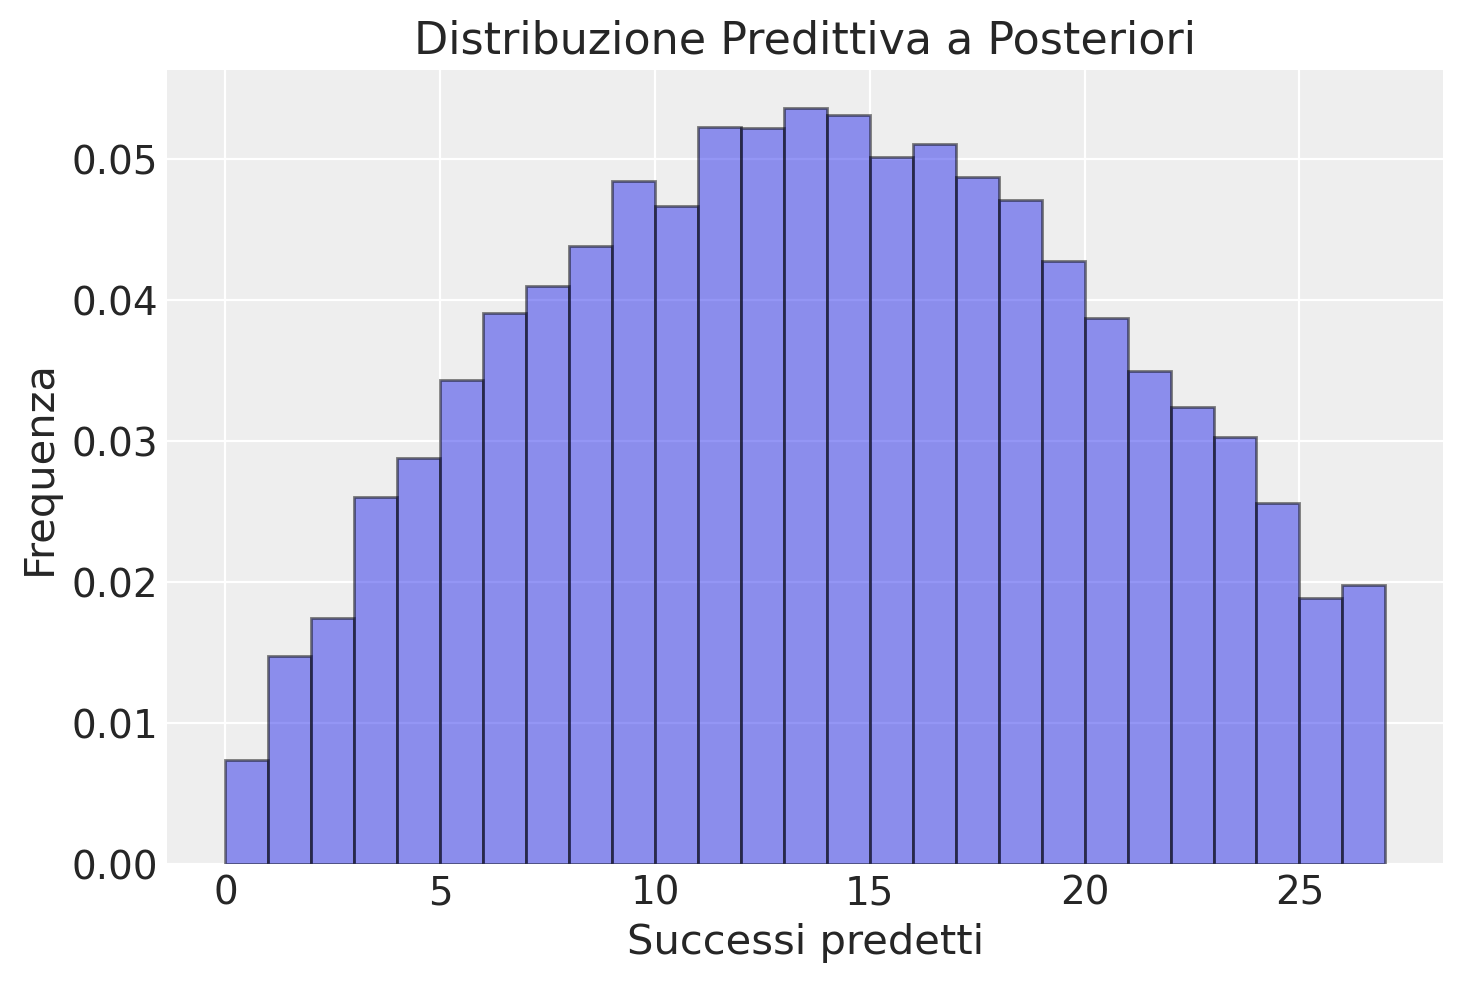

In [48]:
# 'y_pred' è il nome della variabile generata nella sezione `generated quantities` del modello Stan
y_pred_prior = fit3.stan_variable('y_pred_prior')

# Visualizza la distribuzione predittiva a posteriori
plt.hist(y_pred_prior, alpha=0.5, edgecolor='black', density=True, bins=range(0, 28))
plt.title('Distribuzione Predittiva a Priori')
plt.xlabel('Successi predetti')
plt.ylabel('Frequenza')
plt.show()

Avendo osservato 4 successi in 27 tentativi, riteniamo che il nostro modello predittivo basato sui priori sia generalmente adeguato per descrivere i dati campionati. Tuttavia, potrebbe essere vantaggioso considerare l'aggiustamento del nostro modello per concentrare la distribuzione predittiva in un intervallo più ristretto, ad esempio, limitando la variabilità dei successi previsti a un intervallo più stringente, quale tra 0 e 10. Questo approccio potrebbe riflettere una maggiore precisione nelle nostre aspettative riguardo ai risultati futuri, assicurando che le previsioni siano più focalizzate e potenzialmente più allineate con le osservazioni empiriche.

## Informazioni sull'Ambiente di Sviluppo

In [45]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy

Last updated: Wed Apr 10 2024

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

cmdstanpy: 1.2.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

arviz     : 0.18.0
scipy     : 1.13.0
matplotlib: 3.8.3
numpy     : 1.26.4

Watermark: 2.4.3

